In [18]:
%dhist
from collections import namedtuple
servoData = namedtuple('servoData', 'motor, screw, pgain, vgain, cls')

data = [servoData(*line.split(",")) for line in open('servo.data')]
for i, item in enumerate(data):
    clsNew = item.cls.strip()
    clsNew = float(clsNew)
    clsNew = float("{0:.3f}".format(clsNew))
    data[i] = servoData(item.motor, item.screw.lower(), int(item.pgain), int(item.vgain), clsNew)
data[:10]

Directory history (kept in _dh)
0: /Users/prajjwaldangal/fall2020/servo_data


[servoData(motor='E', screw='e', pgain=5, vgain=4, cls=0.281),
 servoData(motor='B', screw='d', pgain=6, vgain=5, cls=0.506),
 servoData(motor='D', screw='d', pgain=4, vgain=3, cls=0.356),
 servoData(motor='B', screw='a', pgain=3, vgain=2, cls=5.5),
 servoData(motor='D', screw='b', pgain=6, vgain=5, cls=0.356),
 servoData(motor='E', screw='c', pgain=4, vgain=3, cls=0.806),
 servoData(motor='C', screw='a', pgain=3, vgain=2, cls=5.1),
 servoData(motor='A', screw='a', pgain=3, vgain=2, cls=5.7),
 servoData(motor='C', screw='a', pgain=6, vgain=5, cls=0.769),
 servoData(motor='D', screw='a', pgain=4, vgain=1, cls=1.031)]

# <h3>Remove any outlier with least trimmed squares</h3>

In [71]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install -c conda-forge --yes --prefix {sys.prefix} jupyter_contrib_nbextensions

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/linkedin_course

  added / updated specs:
    - jupyter_contrib_nbextensions


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    attrs-20.2.0               |     pyh9f0ad1d_0          41 KB  conda-forge
    bleach-3.2.1               |     pyh9f0ad1d_0         111 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         146 KB  conda-forge
    certifi-2020.6.20          |   py37h2987424_2         151 KB  conda-forge
    defusedxml-0.6.0           |             py_0          22 KB  conda-forge
    entrypoints-0.3            |py37hc8dfbb8_1001          12 KB  conda-forge
    icu-67.1                   |       h4a8c4bd_0        12.6 MB  conda-forge
    importlib-metadata-2.0.0   |             py_1          28 KB  conda-forge
    importlib_metadata-2.0.0   |                1           3 

done


In [78]:
!jupyter nbextension enable codefolding/main --sys-prefix

Enabling notebook extension codefolding/main...
      - Validating: problems found:
        - require?  X codefolding/main


In [72]:
# %load ltsfit.py
# ###############################################################################
#
# Copyright (C) 2012-2020, Michele Cappellari
# E-mail: michele.cappellari_at_physics.ox.ac.uk
#
# Updated versions of the software are available from my web page
# http://purl.org/cappellari/software
#
# If you have found this software useful for your research, I would
# appreciate an acknowledgement to the use of the "LTS_LINEFIT program
# described in Cappellari et al. (2013, MNRAS, 432, 1709), which
# combines the Least Trimmed Squares robust technique of Rousseeuw &
# van Driessen (2006) into a least-squares fitting algorithm which
# allows for errors in both variables and intrinsic scatter."
#
# This software is provided as is without any warranty whatsoever.
# Permission to use, for non-commercial purposes is granted.
# Permission to modify for personal or internal use is granted,
# provided this copyright and disclaimer are included unchanged
# at the beginning of the file. All other rights are reserved.
# In particular, redistribution of the code is not allowed.
#
###############################################################################
#
# MODIFICATION HISTORY:
#       V1.0.0: Michele Cappellari, Oxford, 21 March 2011
#       V1.0.1: Included _EXTRA and OVEPLOT, keywords. MC, Oxford, 28 July 2011
#       V1.0.2: Added PIVOT keyword, MC, Oxford, 1 August 2011
#       V1.0.3: Added CLIP keyword. MC, Oxford, 13 March 2013
#       V1.0.4: Fixed program stop affecting earlier versions of IDL.
#           Thanks to Xue-Guang Zhang for reporting the problem
#           and the solution. MC, Turku, 10 July 2013
#       V1.0.5: Scale line spacing with character size in text output.
#           MC, Oxford, 19 September 2013
#       V1.0.6: Check that all input vectors have the same size.
#           MC, Baltimore, 8 June 2014
#       V2.0.0: Converted from IDL into Python. MC, Portsmouth, 23 June 2014
#       V2.0.1: Fixed program stop with zero scatter. MC, Oxford, 23 October 2014
#       V2.0.2: Included _linefit function to avoid np.polyfit bug with weights.
#           MC, 6 November 2014
#       V2.0.3: Uses np.std rather than biweight to estimate scatter upper limit.
#           MC, Oxford, 10 December 2014
#       V2.0.4: Updated documentation. MC, Baltimore, 9 June 2015
#       V2.0.5: Fixed potential program stop without outliers.
#           Thanks to Masato Onodera for a clear report of the problem.
#         - Output boolean mask instead of good/bad indices.
#         - Removed lts_linefit_example from this file.
#         - Print verbose output during calculation.
#           MC, Oxford, 6 July 2015
#       V2.0.6: Optionally pass a legend label. MC, Oxford, 5 September 2015
#       V2.0.7: Fixed potential program stop without outliers.
#           MC, Oxford, 1 October 2015
#       V2.0.8: Fixed potential program stop without outliers in Matplotlib 1.5.
#           Increased maximum intrinsic scatter for brentq, to avoid possible
#           stops in extreme situations. MC, Oxford, 9 December 2015
#       V2.0.9: Use LimeGreen for outliers. MC, Oxford, 8 January 2016
#       V2.0.10: Check for non finite values in input.
#           MC, Oxford, 23 January 2016
#       V2.0.11: Added capsize=0 in plt.errorbar to prevent error bar caps
#           from showing up in PDF. MC, Oxford, 4 July 2016
#       V2.0.12: Fixed: store ab errors in p.ab_err as documented.
#           Thanks to Alison Crocker for the correction.
#           MC, Oxford, 5 September 2016
#       V2.0.13: Increased upper limit of intrinsic scatter accounting for
#           uncertainty of standard deviation with small samples.
#           Michele Cappellari, Oxford, 26 July 2017
#       V2.0.14: Fixed FutureWarning in Numpy 1.14. MC, Oxford, 13 April 2018
#       V2.0.15: Dropped Python 2.7 support. MC, Oxford, 12 May 2018
#       V2.0.16: Fixed clock DeprecationWarning in Python 3.7.
#           MC, Oxford, 27 September 2018
#       V2.0.17: Formatted documentation as dosctring. Included p.rms output.
#           MC, Oxford, 22 January 2020
#       V2.0.18: Properly print significant trailing zeros in results.
#           MC, Oxford, 17 February 2020
#
#------------------------------------------------------------------------------

from time import perf_counter as clock
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats

#----------------------------------------------------------------------------

def _linefit(x, y, sigy=None, weights=None):
    """
    Fit a line y = a + b*x to a set of points (x, y)
    by minimizing chi2 = np.sum(((y - yfit)/sigy)**2)

    """
    v1 = np.ones_like(x)
    if weights is None:
        if sigy is None:
            sw = v1
        else:
            sw = v1/sigy
    else:
        sw = np.sqrt(weights)

    a = np.column_stack([v1, x])
    ab = np.linalg.lstsq(a*sw[:, None], y*sw, rcond=None)[0]

    return ab

#----------------------------------------------------------------------------

def _display_errors(par, sig_par, epsy):
    """
    Print parameters rounded according to their errors

    """
    prec = np.zeros_like(par)
    w = (sig_par != 0) & (par != 0)
    prec[w] = np.ceil(np.log10(np.abs(par[w]))) - np.floor(np.log10(sig_par[w])) + 1
    prec = prec.clip(0)  # negative precisions not allowed
    dg = list(map(str, prec.astype(int)))

    # print on the terminal and save as string

    txt = ['intercept: ', 'slope: ', 'scatter: ']
    for t, d, p, s in zip(txt, dg, par, sig_par):
        print(f"{t:>{12}} {p:#.{d}g} +/- {s:#.2g}")

    txt = ['a=', 'b=', '\\varepsilon_y=']
    if not epsy:
        txt = txt[:-1]
    string = ''
    for t, d, p, s in zip(txt, dg, par, sig_par):
        string += f"${t}{p:#.{d}g}\\pm{s:#.2g}$\n"

    return string

#------------------------------------------------------------------------------

def _residuals(ab, x, y, sigx, sigy):
    """
    See equation (6) of Cappellari et al. (2013, MNRAS, 432, 1709)

    """
    res = (ab[0] + ab[1]*x - y) / np.sqrt((ab[1]*sigx)**2 + sigy**2)

    return res

#----------------------------------------------------------------------------

def _fitting(x, y, sigx, sigy, ab):

    ab, pcov, infodict, errmsg, success = optimize.leastsq(
        _residuals, ab, args=(x, y, sigx, sigy), full_output=1)

    if pcov is None or np.any(np.diag(pcov) < 0):
        sig_AB = np.full(2, np.inf)
        chi2 = np.inf
    else:
        chi2 = np.sum(infodict['fvec']**2)
        sig_AB = np.sqrt(np.diag(pcov)) # ignore covariance

    return ab, sig_AB, chi2

#----------------------------------------------------------------------------

def _fast_algorithm(x, y, sigx, sigy, h):

    # Robust least trimmed squares regression.
    # Pg. 38 of Rousseeuw & van Driessen (2006)
    # http://dx.doi.org/10.1007/s10618-005-0024-4
    #
    m = 500 # Number of random starting points
    abv = np.empty((m, 2))
    chi2v = np.empty(m)
    for j in range(m): # Draw m random starting points
        w = np.random.choice(x.size, 2, replace=False)
        ab = _linefit(x[w], y[w])  # Find a line going trough two random points
        for k in range(3): # Run C-steps up to H_3
            res = _residuals(ab, x, y, sigx, sigy)
            good = np.argsort(np.abs(res))[:h] # Fit the h points with smallest errors
            ab, sig_ab, chi_sq = _fitting(x[good], y[good], sigx[good], sigy[good], ab)
        abv[j, :] = ab
        chi2v[j] = chi_sq

    # Perform full C-steps only for the 10 best results
    #
    w = np.argsort(chi2v)
    nbest = 10
    chi_sq = np.inf
    for j in range(nbest):
        ab1 = abv[w[j], :]
        while True: # Run C-steps to convergence
            abOld = ab1
            res = _residuals(ab1, x, y, sigx, sigy)
            good1 = np.argsort(np.abs(res))[:h] # Fit the h points with smallest errors
            ab1, sig_ab1, chi1_sq = _fitting(x[good1], y[good1], sigx[good1], sigy[good1], ab1)
            if np.allclose(abOld, ab1):
                break
        if chi_sq > chi1_sq:
            ab = ab1  # Save best solution
            good = good1
            chi_sq = chi1_sq

    mask = np.zeros_like(x, dtype=bool)
    mask[good] = True

    return ab, mask

#------------------------------------------------------------------------------

class lts_linefit():
    """
    LTS_LINEFIT
    -----------

    Purpose
    -------

    Best straight-line *robust* fit to data with errors in
    both coordinates while fitting for the intrinsic scatter.
    See `Cappellari et al. (2013a, Sec.3.2)
    <https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C>`_

    Explanation
    -----------

    Linear Least-squares approximation in one-dimension (y = a + b*x),
    when both x and y data have errors and allowing for intrinsic
    scatter in the relation.

    Outliers are iteratively clipped using the extremely robust
    FAST-LTS technique by `Rousseeuw & van Driessen (2006)
    <http://dx.doi.org/10.1007/s10618-005-0024-4>`_
    (See also `Rousseeuw 1987)
    <http://books.google.co.uk/books?id=woaH_73s-MwC&pg=PA15>`_

    Calling Sequence
    ----------------

    .. code-block:: python

        p = lts_linefit(x, y, sigx, sigy, clip=2.6, epsy=True, corr=True,
                      frac=None, pivot=None, plot=True, text=True)

    The output values are stored as attributes of "p".
    See usage example at the bottom of this file.

    Input Parameters
    ----------------

    x, y:
        vectors of size N with the measured values.
    sigx, sigy:
        vectors of size N with the 1sigma errors in x and y.
    clip:
        values deviating more than clip*sigma from the best fit are
        considered outliers and are excluded from the linear fit.
    epsy:
        if True, the intrinsic scatter is printed on the plot.
    corr:
        if True, the correlation coefficients are printed on the plot.
    frac:
        fractions of values to include in the LTS stage.
        Up to a fraction "frac" of the values can be outliers.
        One must have 0.5 < frac < 1  (default frac=0.5).

        NOTE: Set frac=1, to turn off outliers detection.
    label:
        optional string label to create a legend outside the procedure.
    pivot:
        if this is not None, then lts_linefit fits the relation::

            y = a + b*(x - pivot)

        pivot is called x_0 in eq.(6) of Cappellari et al. (2013)
        Use of this keyword is *strongly* recommended and a suggested
        value is pivot ~ np.mean(x). This keyword is important to
        reduce the covariance between a and b.
    plot:
        if True a plot of the fit is produced.
    text:
        if True, the best fitting parameters are printed on the plot.

    Output Parameters
    -----------------

    The output values are stored as attributed of the lts_linefit class.

    p.ab:
        best fitting parameters [a, b]
    p.ab_err:
        1*sigma formal errors [a_err, b_err] on a and b.
    p.mask:
        boolean vector with the same size of x and y.
        It contains True  for the elements of (x, y) which were included in
        the fit and False for the outliers which were automatically clipped.
    p.rms:
        rms = np.std(fit - y) beteween the data and the fitted relation.
    p.sig_int:
        intrinsic scatter around the linear relation.
        sig_int is called epsilon_y in eq.(6) of Cappellari et al. (2013).
    p.sig_int_err:
        1*sigma formal error on sig_int.

    """

    def _find_outliers(self, sig_int, x, y, sigx, sigy1, h, offs, clip):

        sigy = np.sqrt(sigy1**2 + sig_int**2) # Gaussian intrinsic scatter

        if h == x.size: # No outliers detection

            ab = _linefit(x, y, sigy=sigy)  # quick initial guess
            ab, sig_ab, chi_sq = _fitting(x, y, sigx, sigy, ab)
            mask = np.ones_like(x, dtype=bool)  # No outliers

        else: # Robust fit and outliers detection

            # Initial estimate using the maximum breakdown of
            # the method of 50% but minimum efficiency
            #
            ab, mask = _fast_algorithm(x, y, sigx, sigy, h)

            # inside-out outliers removal
            #
            while True:
                res = _residuals(ab, x, y, sigx, sigy)
                sig = np.std(res[mask], ddof=2)
                maskOld = mask
                mask = np.abs(res) < clip*sig
                ab, sig_ab, chi_sq = _fitting(x[mask], y[mask], sigx[mask], sigy[mask], ab)
                if np.array_equal(mask, maskOld):
                    break

        # To determine 1sigma error on the intrinsic scatter the chi2
        # is decreased by 1sigma=sqrt(2(h-2)) while optimizing (a,b)
        #
        h = mask.sum()
        dchi = np.sqrt(2*(h - 2)) if offs else 0.

        self.ab = ab
        self.ab_err = sig_ab
        self.mask = mask

        err = (chi_sq + dchi)/(h - 2.) - 1.
        print('sig_int: %10.4f  %10.4f' % (sig_int, err))

        return err

#------------------------------------------------------------------------------

    def _single_fit(self, x, y, sigx, sigy, h, clip):

        if self._find_outliers(0, x, y, sigx, sigy, h, 0, clip) < 0:
            print('No intrinsic scatter or errors overestimated')
            sig_int = 0.
            sig_int_err = 0.
        else:
            sig1 = 0.
            res = self.ab[0] + self.ab[1]*x - y  # Total residuals ignoring measurement errors
            std = np.std(res[self.mask], ddof=2)
            sig2 = std*(1 + 3/np.sqrt(2*self.mask.sum()))  # Observed scatter + 3sigma error
            print('Computing sig_int')
            sig_int = optimize.brentq(self._find_outliers, sig1, sig2,
                                args=(x, y, sigx, sigy, h, 0, clip), rtol=1e-3)
            print('Computing sig_int error') # chi2 can always decrease
            sigMax_int = optimize.brentq(self._find_outliers, sig_int, sig2,
                                args=(x, y, sigx, sigy, h, 1, clip), rtol=1e-3)
            sig_int_err = sigMax_int - sig_int

        self.sig_int = sig_int
        self.sig_int_err = sig_int_err

        print('Repeat at best fitting solution')
        self._find_outliers(sig_int, x, y, sigx, sigy, h, 0, clip)

#------------------------------------------------------------------------------

    def __init__(self, x0, y, sigx, sigy, clip=2.6, epsy=True, label='Fitted',
                 label_clip='Clipped', frac=None, pivot=0, plot=True,
                 text=True, corr=True):

        assert x0.size == y.size == sigx.size == sigy.size, '[X, Y, SIGX, SIGY] must have the same size'
        assert np.all(np.isfinite(np.hstack([x0, y, sigx, sigy]))), 'Input contains non finite values'

        t = clock()

        x = x0 - pivot

        p = 2  # two dimensions
        n = x.size
        h = int((n + p + 1)/2) if frac is None else int(max(round(frac*n), (n + p + 1)/2))

        self._single_fit(x, y, sigx, sigy, h, clip)
        self.rms = np.std(self.ab[0] + self.ab[1]*x[self.mask] - y[self.mask], ddof=2)

        par = np.append(self.ab, self.sig_int)
        sig_par = np.append(self.ab_err, self.sig_int_err)
        print('################# Values and formal errors ################')
        string = _display_errors(par, sig_par, epsy)
        print(f'Observed rms scatter: {self.rms:#.2g}')
        if pivot:
            print('y = a + b*(x - pivot) with pivot = %.4g' % pivot)
        print('Spearman r=%.2g and p=%.2g' % stats.spearmanr(x, y))
        print('Pearson r=%.2g and p=%.2g' % stats.pearsonr(x, y))
        print('##########################################################')

        print('seconds %.2f' % (clock() - t))

        if plot:

            plt.errorbar(x0[self.mask], y[self.mask], xerr=sigx[self.mask], yerr=sigy[self.mask],
                         fmt='ob', capthick=0, capsize=0, label=label)
            if not np.all(self.mask):
                plt.errorbar(x0[~self.mask], y[~self.mask], xerr=sigx[~self.mask], yerr=sigy[~self.mask],
                            fmt='d', color='LimeGreen', capthick=0, capsize=0, label=label_clip)
            plt.autoscale(False)
            plt.title('Best fit, 1$\sigma$ (68%) and 2.6$\sigma$ (99%)')

            # Extends lines well beyond plot to allow for rescaling.
            # Lines are plotted below the symbols using z-buffer
            print("max(x), min(x): {} {} (After pivot)\nmax(y), min(y): {} {}".format(\
                            np.max(x), np.min(x),np.max(y), np.min(y)))
            xmin, xmax = np.min(x0), np.max(x0)
            dx = xmax - xmin
            xlimits = np.array([xmin - dx, xmax + dx])
            y1 = par[0] + par[1]*(xlimits - pivot)
            plt.plot(xlimits, y1, '-k',
                     xlimits, y1 + self.rms, '--r',
                     xlimits, y1 - self.rms, '--r',
                     xlimits, y1 + 2.6*self.rms, ':r',
                     xlimits, y1 - 2.6*self.rms, ':r', linewidth=2, zorder=1)

            ax = plt.gca()
            if text:
                string += f'$\Delta={self.rms:#.2g}$\n'
                if pivot:
                    string += '$(x_0=%.4g)$' % pivot
                ax.text(0.05, 0.95, string, horizontalalignment='left',
                        verticalalignment='top', transform=ax.transAxes)

            if corr:
                txt = '${\\rm Spearman/Pearson}$\n'
                txt += '$r=%.2g\, p=%.2g$\n' % stats.spearmanr(x, y)
                txt += '$r=%.2g\, p=%.2g$\n' % stats.pearsonr(x, y)
                ax.text(0.95, 0.95, txt, horizontalalignment='right',
                        verticalalignment='top', transform=ax.transAxes)

            ax.minorticks_on()
            ax.tick_params(length=10, width=1, which='major')
            ax.tick_params(length=5, width=1, which='minor')

#------------------------------------------------------------------------------


In [73]:
#!/usr/bin/env python
# V1.0.0: Michele Cappellari, Oxford, 07 March 2011
# V1.0.1: Fixed deprecation warning. MC, Oxford, 1 October 2015
# V1.0.2: Changed imports for ltsfit as package. MC, Oxford, 17 April 2018    
import random
import numpy as np
import matplotlib.pyplot as plt

#------------------------------------------------------------------------------

def lts_linefit_example():
    """
    Usage example for lts_linefit()
    just use vgain as x, cls as y

    """
    ntot = len(data) # Number of values

    # Coefficients of the test line
    #
    a = 10.
    b = 0.5

    n = int(ntot*0.6)  # 60% good values
    c = 0
    # np.insert(array, ind, value)
    x = np.array([])
    while c < n:
        x = np.insert(x, c, data[random.randint(0, n-1)].vgain)
        c += 1
    print(x)
    y = a + b * x
    mxY = max(y)
    mnY = min(y)
    print("len(x), len(y): {}, {}\nmax(y): {}, min(y): {}".format(len(x), len(y),mxY,mnY))
    
    sig_int = 0.3 # Intrinsic scatter in y
    y += np.random.normal(0, sig_int, n)
    print("len(x), len(y): ", len(x), len(y))
    
    sigx = 0.1 # Observational error in x
    sigy = 0.2 # Observational error in y
    x += np.random.normal(0, sigx, n)
    y += np.random.normal(0, sigy, n)
    print("len(x), len(y): ", len(x), len(y))
    
    # Outliers produce a background of spurious values
    # intersecting with the true distribution
    #
    nout = int(ntot*0.4)   # 40% outliers
    x1 = np.random.uniform((max(x) + min(x))/2, max(x), nout)
    y1 = np.random.uniform(mnY-(mxY-mnY)//2, mxY+(mxY-mnY)//2, nout)

    # Combines the good values and the outliers in one vector
    #
    x = np.append(x, x1)
    y = np.append(y, y1)

    sigx = np.full_like(x, sigx)  # Adopted error in x
    sigy = np.full_like(x, sigy)  # Adopted error in y

    plt.clf()
    p = lts_linefit(x, y, sigx, sigy, pivot=np.median(x), text=False, corr=False)
    plt.xlabel('x')
    plt.ylabel('$y, a + b\ (x - x_{0})$')
    plt.pause(1)

    # Illustrates how to obtain the best-fitting values from the class
    print("The best fitting parameters are:", p.ab)
    

<h2>Plane fit for pgain, vgain, and class</h2>

In [74]:
def lts_planefit_example():
    """
    Usage example for lts_planefit()

    """
    ntot = len(data)  # Number of values

    # Coefficients of the test line
    #
    a = 10.
    b = 2.
    c = 1.

    n = int(ntot*0.6)
    x = np.array([])
    y = np.array([])
    count = 0
    while count < n:
        ind = random.randint(0, n-1)
        x = np.insert(x, count, data[ind].vgain)
        y = np.insert(y, count, data[ind].pgain)
        count += 1
    z = a + b*x + c*y

    sig_int = 1  # Intrinsic scatter in z
    z = np.random.normal(z, sig_int, n)

    sigx = 0.2  # Observational error in x
    sigy = 0.4  # Observational error in y
    sigz = 0.4  # Observational error in z
    x = np.random.normal(x, sigx, n)
    y = np.random.normal(y, sigy, n)
    z = np.random.normal(z, sigz, n)

#     # Outliers produce a background of spurious values
#     # intersecting with the true distribution
#     #
#     nout = int(ntot*0.4)  # 40% outliers
#     x1 = np.random.uniform(10, 30, nout)
#     y1 = np.random.uniform(20, 40, nout)
#     z1 = np.random.uniform((max(z) + min(z))/2, max(z), nout)

#     # Combines the good values and the outliers in one vector
#     #
#     x = np.append(x, x1)
#     y = np.append(y, y1)
#     z = np.append(z, z1)

#     sigx = np.full_like(x, sigx)  # Adopted error in x
#     sigy = np.full_like(x, sigy)  # Adopted error in y
#     sigz = np.full_like(x, sigz)  # Adopted error in z

#     plt.clf()
#     p = lts_planefit(x, y, z, sigx, sigy, sigz, pivotx=np.median(x), pivoty=np.median(y))
#     plt.xlabel('z')
#     plt.ylabel('$a + b\ (x - x_{0}) + c\ (y - y_{0})$')
#     plt.pause(1)

#     # Illustrates how to obtain the best-fitting values from the class
#     print("The best fitting parameters are:", p.abc)

[2. 3. 4. 2. 2. 5. 1. 4. 4. 1. 1. 3. 3. 3. 1. 1. 4. 1. 1. 4. 1. 1. 2. 4.
 2. 2. 1. 2. 2. 3. 2. 2. 2. 3. 3. 1. 2. 4. 2. 2. 3. 3. 1. 2. 3. 4. 4. 3.
 5. 3. 1. 2. 4. 1. 5. 4. 2. 3. 2. 3. 1. 2. 1. 2. 2. 3. 2. 1. 2. 1. 1. 1.
 5. 4. 2. 1. 4. 4. 3. 5. 2. 2. 3. 2. 1. 3. 1. 1. 2. 4. 2. 4. 1. 1. 2. 1.
 5. 5. 4. 1.]
len(x), len(y): 100, 100
max(y): 12.5, min(y): 10.5
len(x), len(y):  100 100
len(x), len(y):  100 100
sig_int:     0.0000      3.7766
Computing sig_int
sig_int:     0.0000      3.7766
sig_int:     0.5322     -0.3806
sig_int:     0.4834     -0.2695
sig_int:     0.3731      0.1111
sig_int:     0.4053     -0.0238
sig_int:     0.3996     -0.0017
sig_int:     0.3992      0.0000
sig_int:     0.3994     -0.0008
Computing sig_int error
sig_int:     0.3992      0.1240
sig_int:     0.5322     -0.2566
sig_int:     0.4425     -0.0292
sig_int:     0.4343     -0.0026
sig_int:     0.4335      0.0000
sig_int:     0.4337     -0.0007
Repeat at best fitting solution
sig_int:     0.3992      0.0000
######

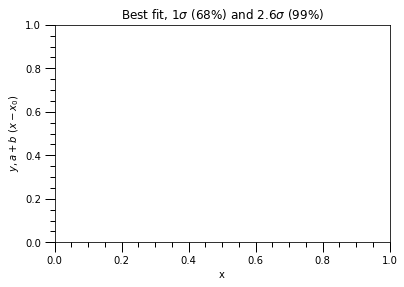

The best fitting parameters are: [11.57609078  0.463579  ]


In [75]:
   
    
#------------------------------------------------------------------------------

if __name__ == '__main__':
    """
    p in our case could be: 1 for each of pgain, vgain
       so 2 total
    r stands for residual
    1 sigma error
    """
    lts_linefit_example()
    # lts_planefit_example()
    
    

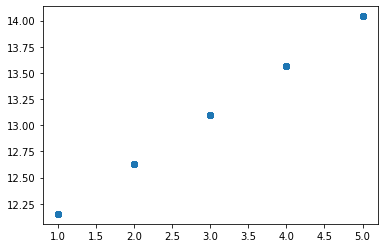

In [63]:
m = 0.472
c = 11.681
x = np.array([])
n = len(data)
count = 0
while count < n:
    x = np.insert(x, count, data[random.randint(0, n-1)].vgain)
    count += 1
    
y = m * x + c
plt.plot(x, m*x+c, 'o')

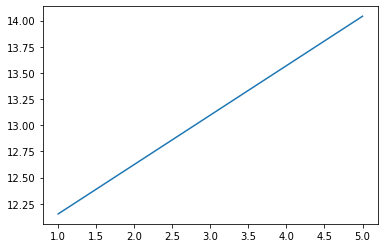

In [64]:
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

In [62]:
len(x), len(y)

(167, 167)